<a href="https://colab.research.google.com/github/kaylawright26/Final-Project-IoT-AAI-530/blob/main/IoT_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IoT Final Team Project



# Importing Libraries, Data, Sanity Checks, and Feature Engineering

In [1]:
# Importing necessary libraries
import numpy as np                                                                               
import pandas as pd 
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences
import tensorflow as tf
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import optimizers

In [2]:
# Mounting google drive to import datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/train_ML_IOT.csv')

In [4]:
# Checking shape of training set
df.shape

(48120, 4)

In [5]:
# Checking count and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
# Checking statistical information on this dataset
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [7]:
# Checking to see the first 5 rows of the dataset
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [8]:
# Dropping ID column because it will not be helpful for our model
df.drop(["ID"], axis = 1, inplace = True)

In [9]:
# Checking for duplicated rows
df[df.duplicated()].count()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

In [10]:
# Checking for nan values
df[df.isna()].count()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

### Feature Engineering

In [11]:
# Converting datetime to unix time
df['DateTime'] = pd.to_datetime(df['DateTime'])
df["unix_time_column"] = df["DateTime"].apply(lambda x: x.timestamp())

In [12]:
# Checking if the datatype conversion worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          48120 non-null  datetime64[ns]
 1   Junction          48120 non-null  int64         
 2   Vehicles          48120 non-null  int64         
 3   unix_time_column  48120 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.5 MB


In [13]:
# Making Weekday, Year, Month, Day, Time, Week, and Quarter
df['Weekday'] = [datetime.weekday(date) for date in df.DateTime]
df['Year'] = [date.year for date in df.DateTime]
df['Month'] = [date.month for date in df.DateTime]
df['Day'] = [date.day for date in df.DateTime]
df['Seconds'] = [((date.hour*60+(date.minute))*60)+date.second for date in df.DateTime]
df['Week'] = [date.week for date in df.DateTime]
df['Quarter'] = [date.quarter for date in df.DateTime]

In [14]:
df.tail()

,DateTime,Junction,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
48115,2017-06-30 19:00:00,4,11,1.498849e+09,4,2017,6,30,68400,26,2
48116,2017-06-30 20:00:00,4,30,1.498853e+09,4,2017,6,30,72000,26,2
48117,2017-06-30 21:00:00,4,16,1.498856e+09,4,2017,6,30,75600,26,2
48118,2017-06-30 22:00:00,4,22,1.498860e+09,4,2017,6,30,79200,26,2
48119,2017-06-30 23:00:00,4,12,1.498864e+09,4,2017,6,30,82800,26,2


# Data Visualization

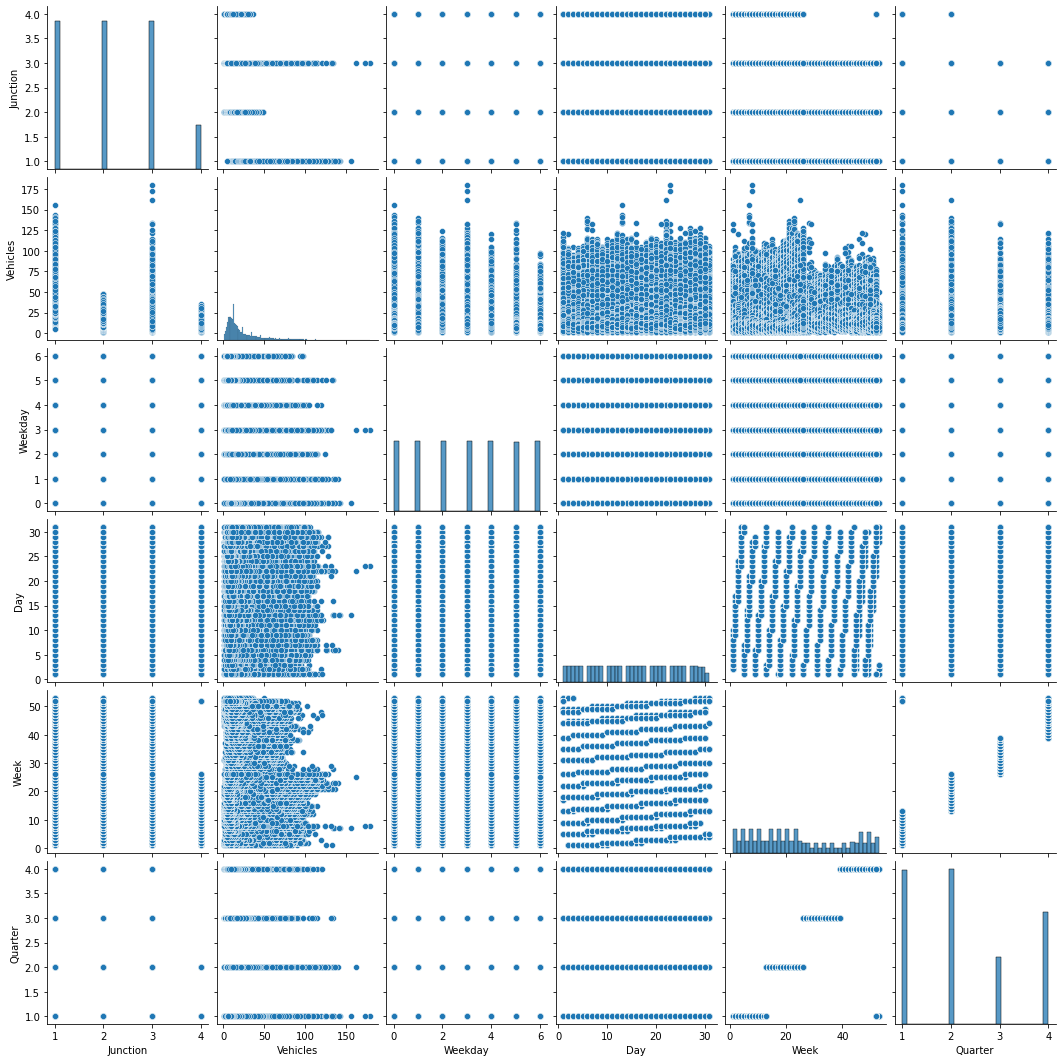

In [15]:
sns.pairplot(df, x_vars = ["Junction", "Vehicles", "Weekday", "Day", "Week", "Quarter"], y_vars = ["Junction", "Vehicles", "Weekday", "Day", "Week", "Quarter"])

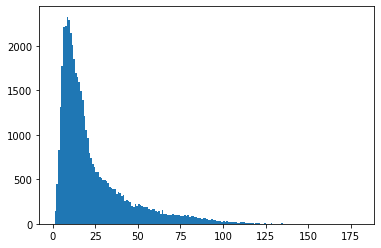

In [16]:
binwidth = 1
plt.hist(df.Vehicles, bins = range(min(df.Vehicles), max(df.Vehicles) + binwidth, binwidth))
plt.show()

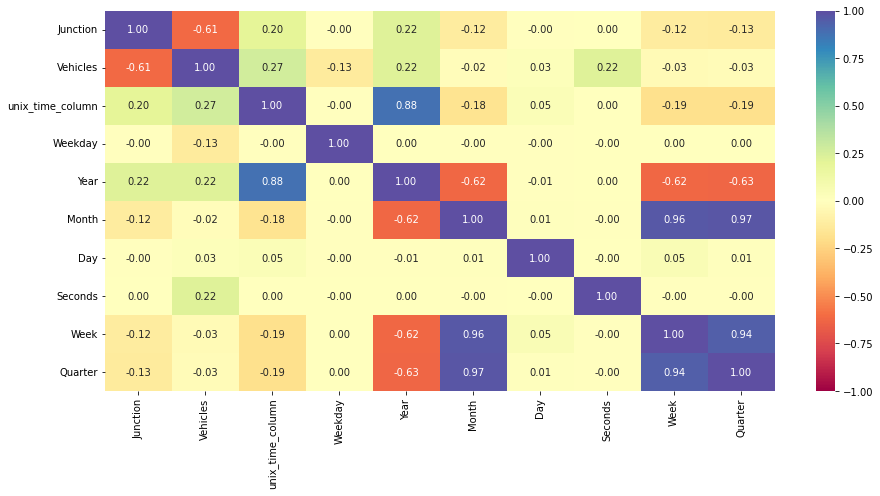

In [17]:
# Code below makes a heatmap to see important correlations
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

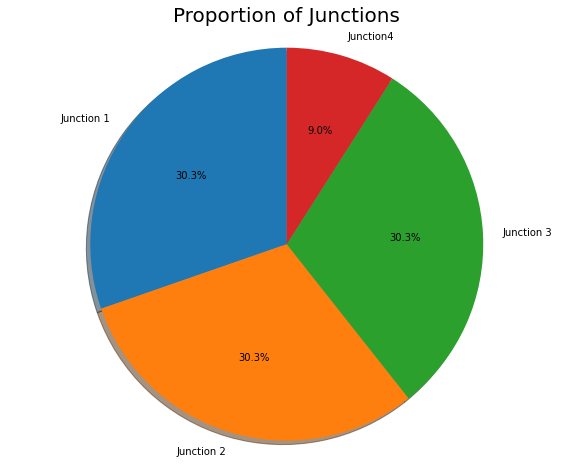

In [18]:
labels = 'Junction 1', 'Junction 2', 'Junction 3', 'Junction4'
sizes = [df.Junction[df['Junction']==1].count(), df.Junction[df['Junction']==2].count(), df.Junction[df['Junction']==3].count(), df.Junction[df['Junction']==4].count()]
#explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Junctions", size = 20)
plt.show()

In [19]:
# class count
class_count_0, class_count_1, class_count_2, class_count_3 = df['Junction'].value_counts()

# Separate class
class_1 = df[df['Junction'] == 1]
class_2 = df[df['Junction'] == 2]
class_3 = df[df['Junction'] == 3]
class_4 = df[df['Junction'] == 4]# print the shape of the class
print('Junction 1:', class_1.shape)
print('Junction 2:', class_2.shape)
print('Junction 3:', class_3.shape)
print('Junction 4:', class_4.shape)

Junction 1: (14592, 11)
Junction 2: (14592, 11)
Junction 3: (14592, 11)
Junction 4: (4344, 11)


                                             |          | [  0%]   00:00 -> (? left)


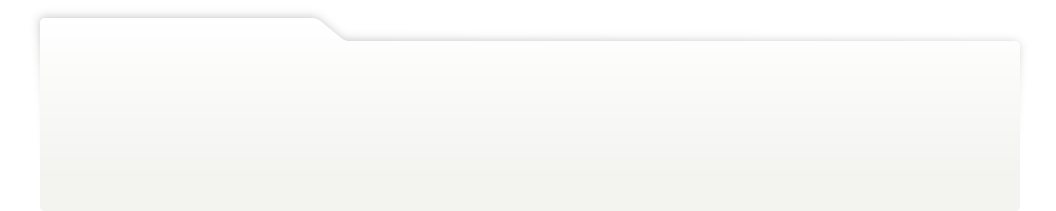
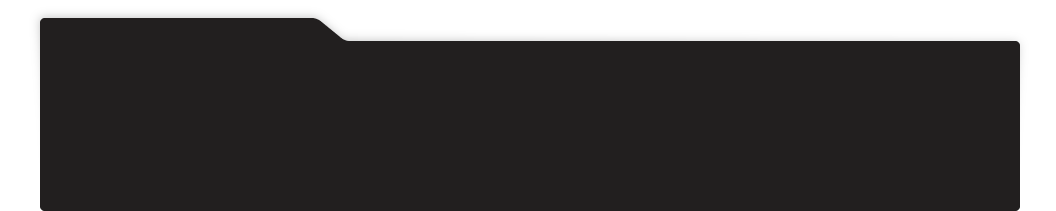
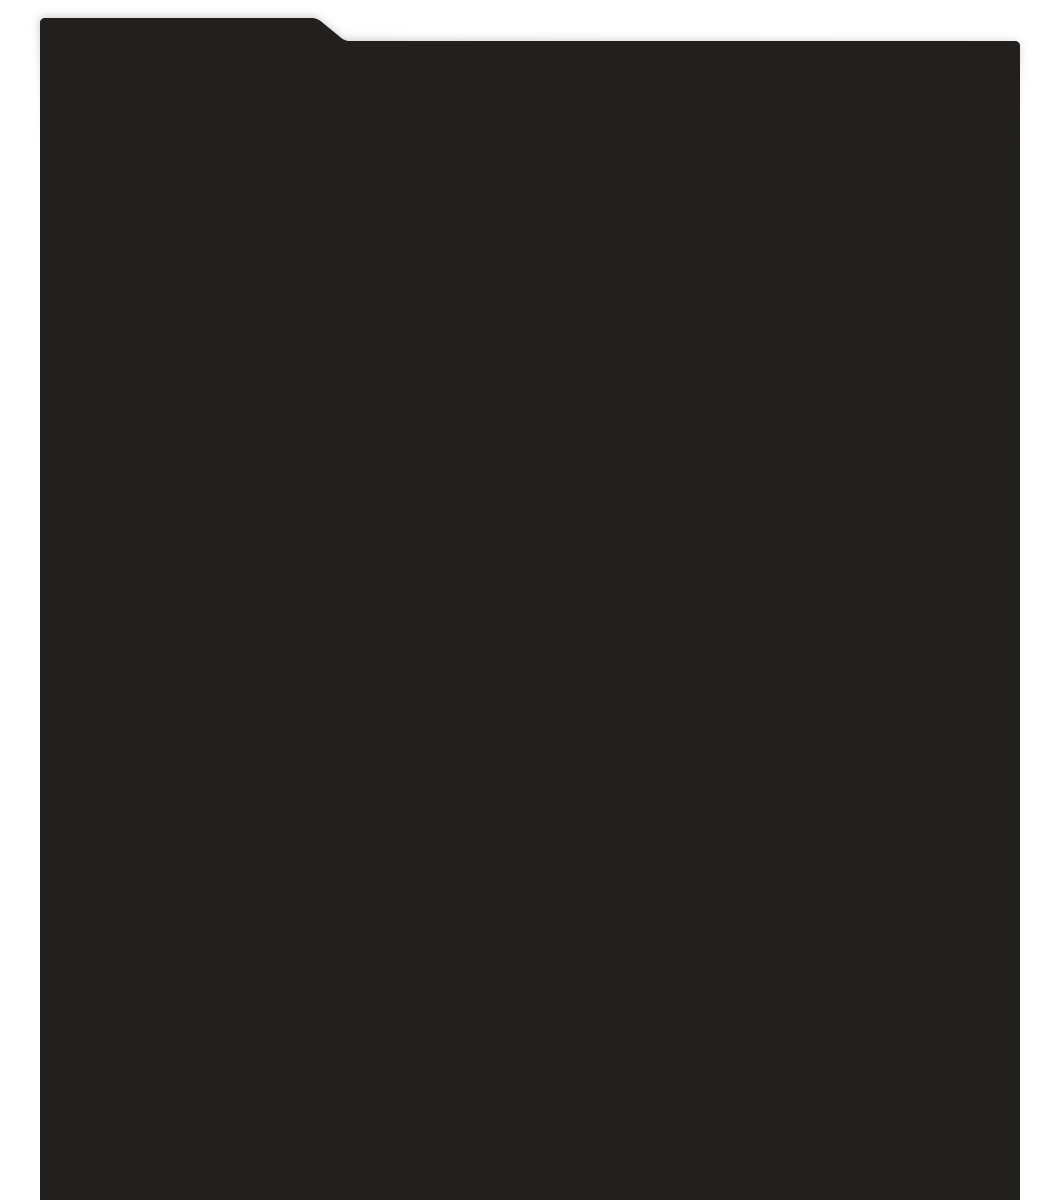
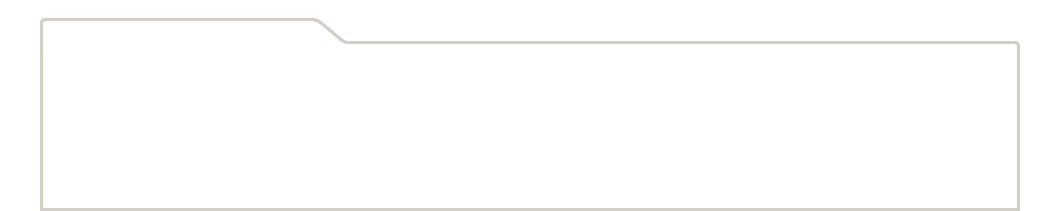
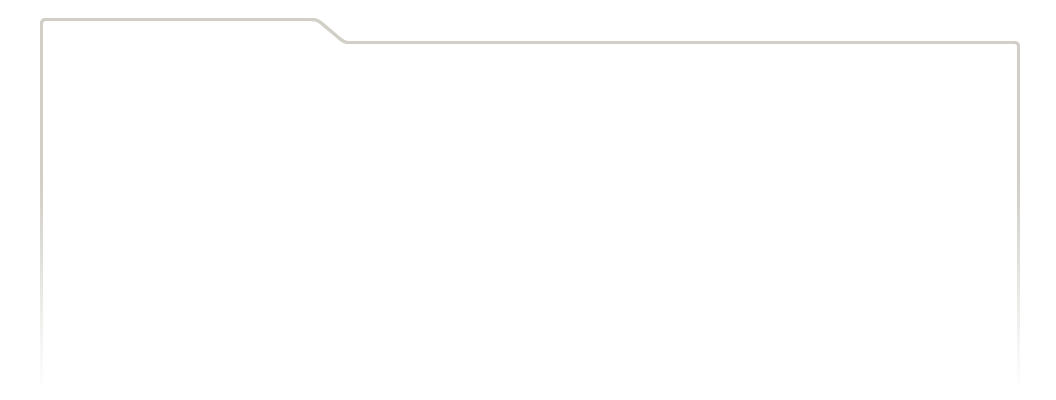
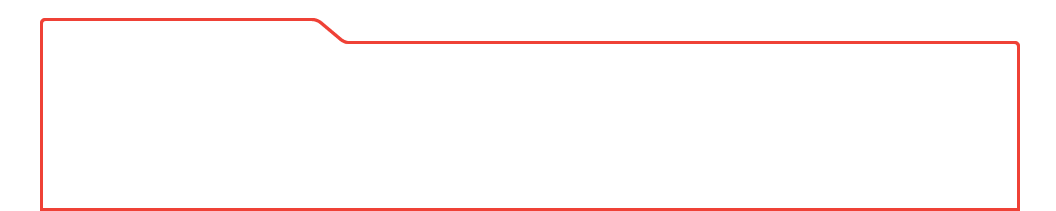
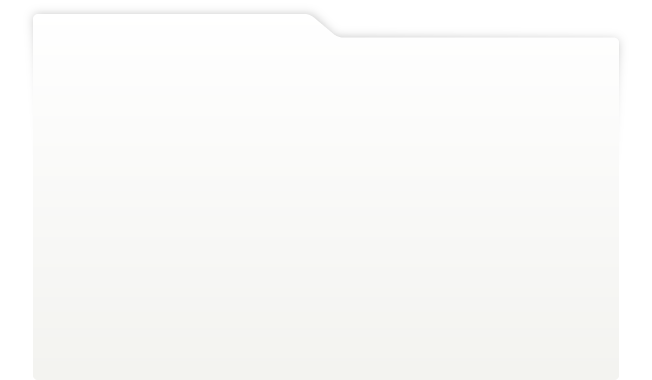
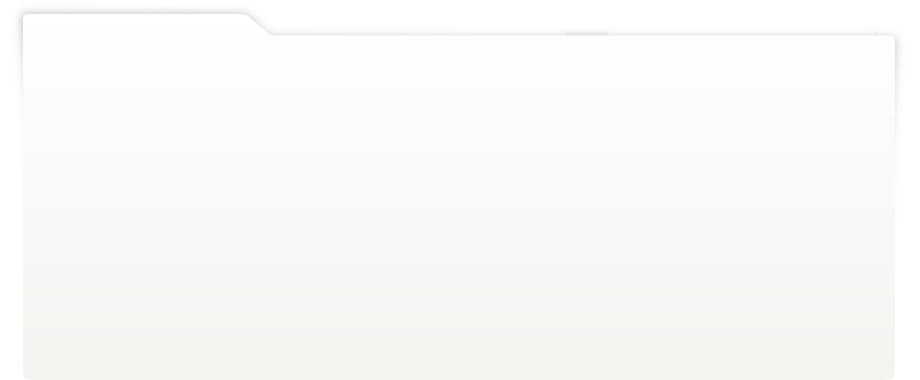
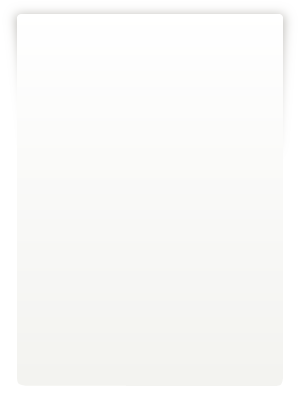
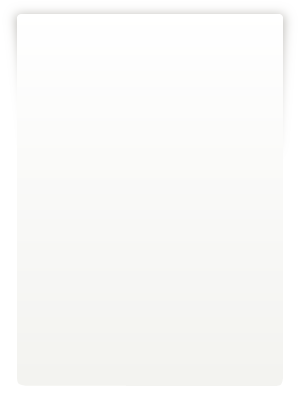
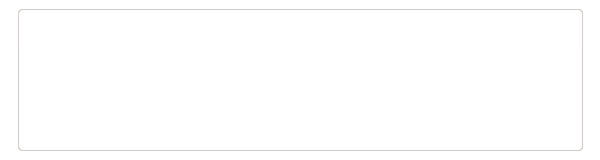
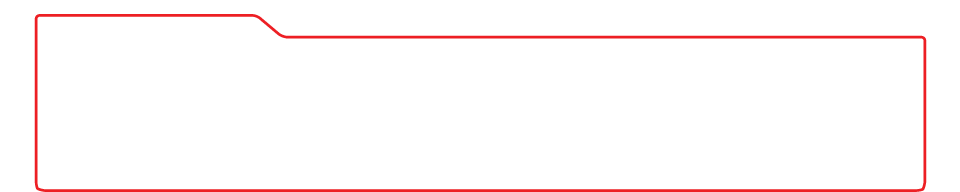
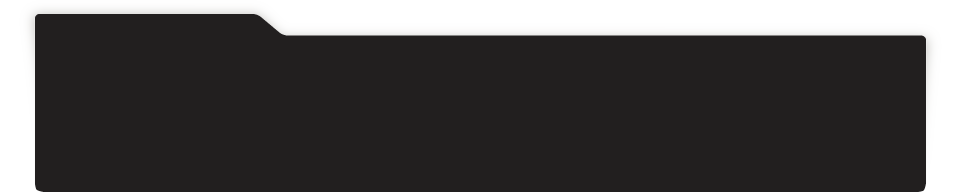
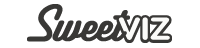
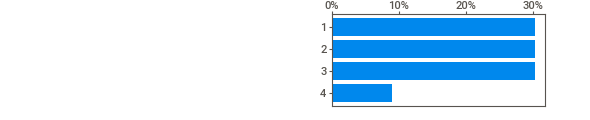
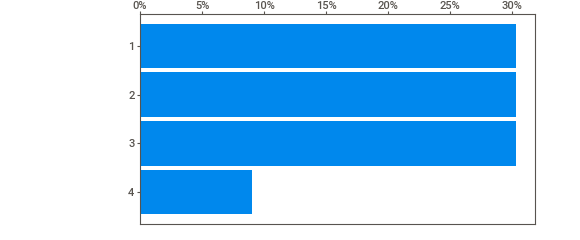
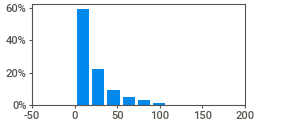
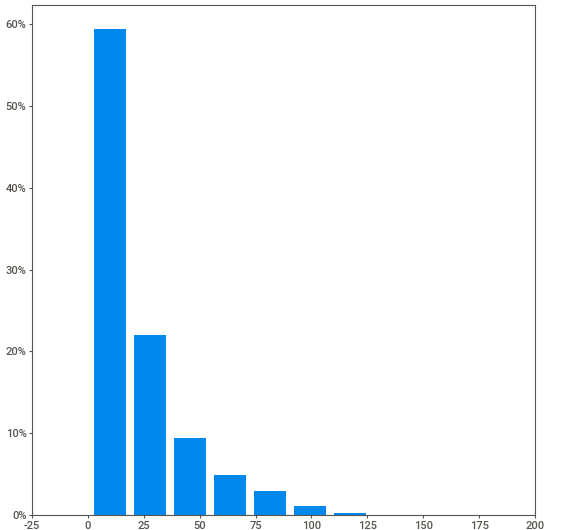
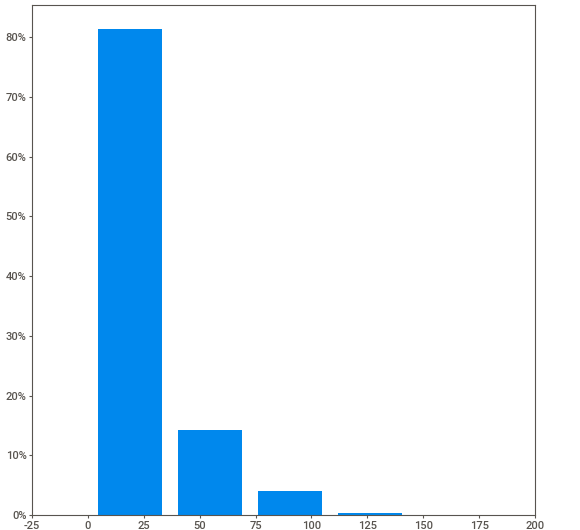
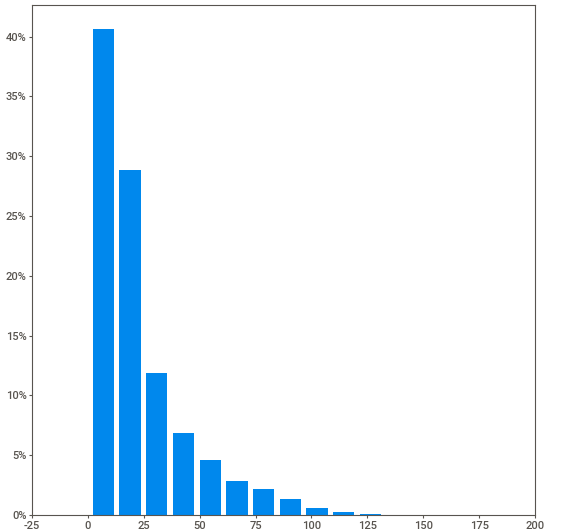
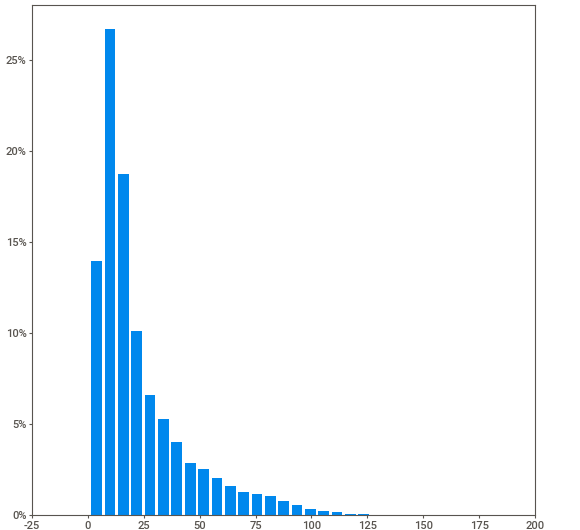
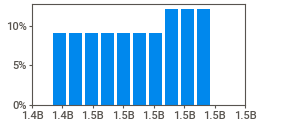
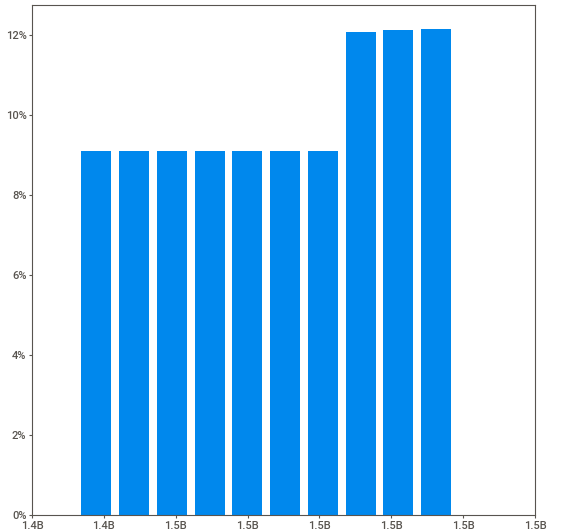
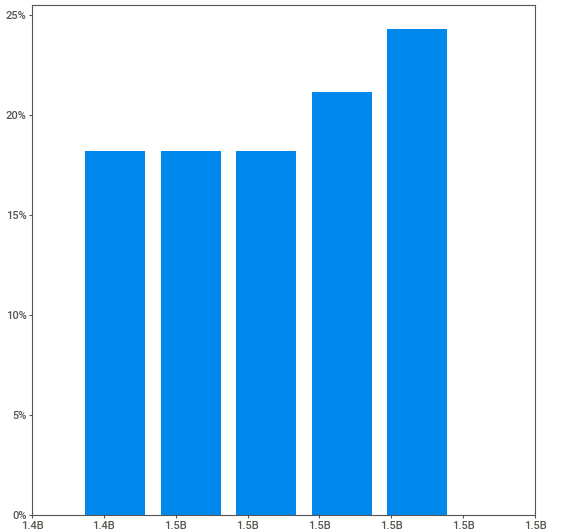
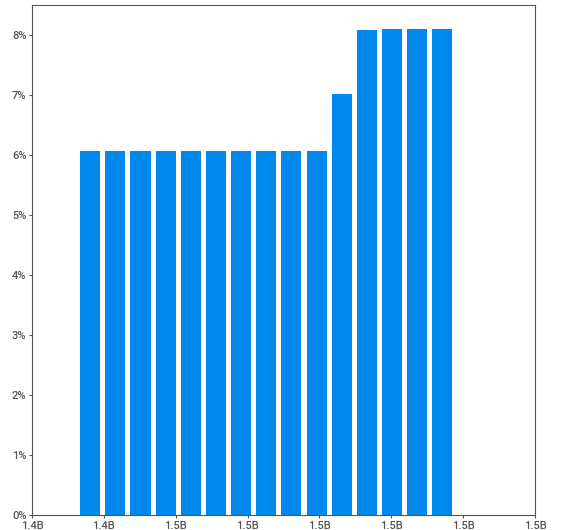
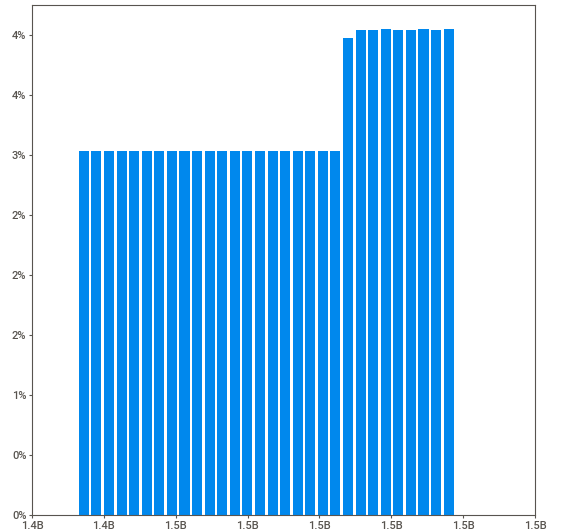
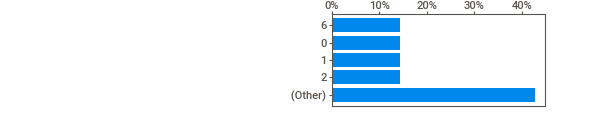
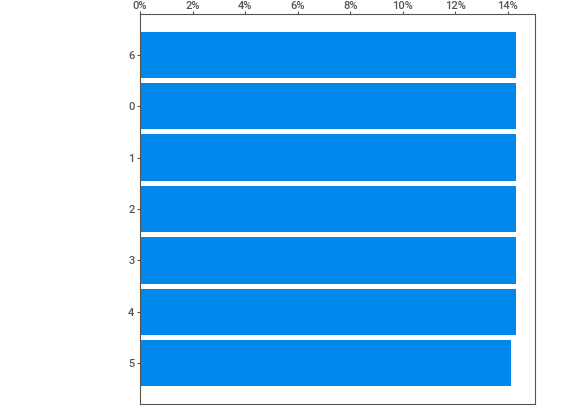
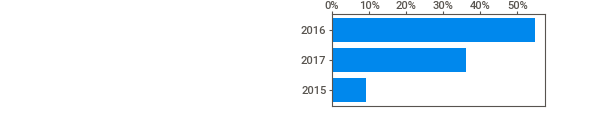
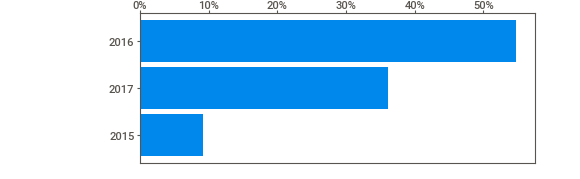
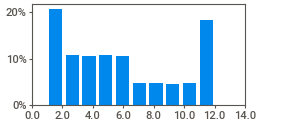
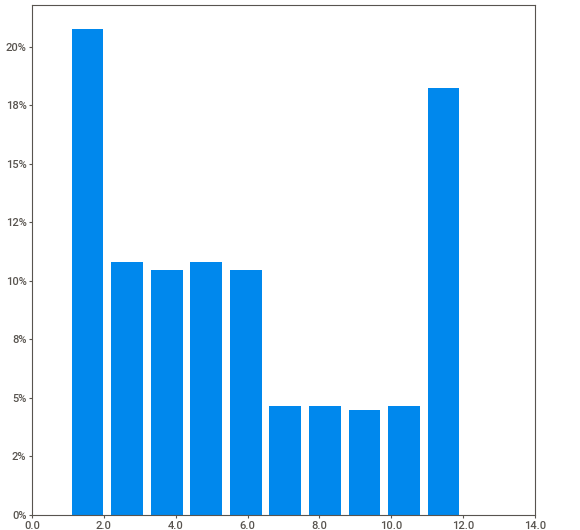
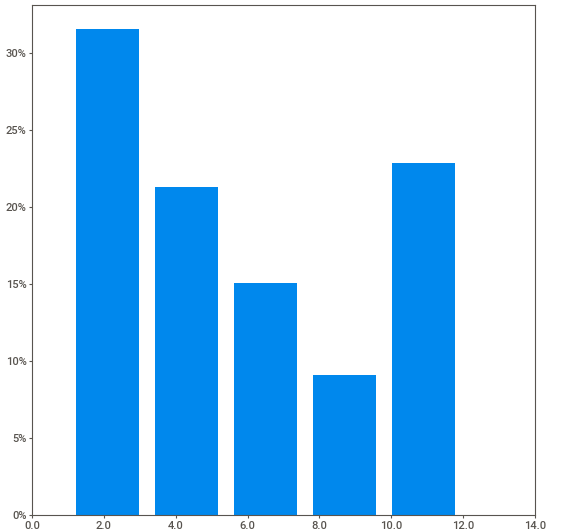
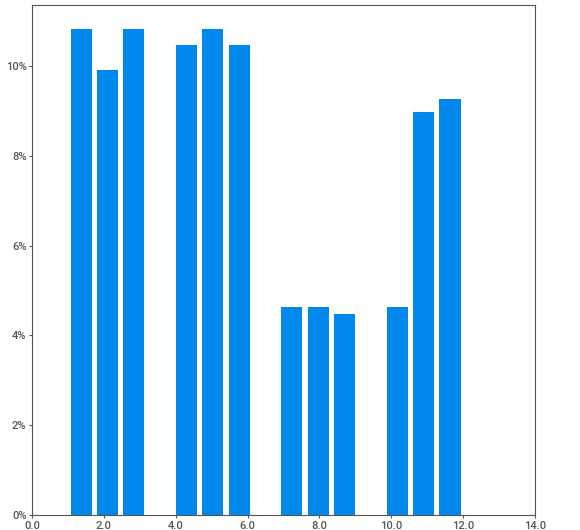
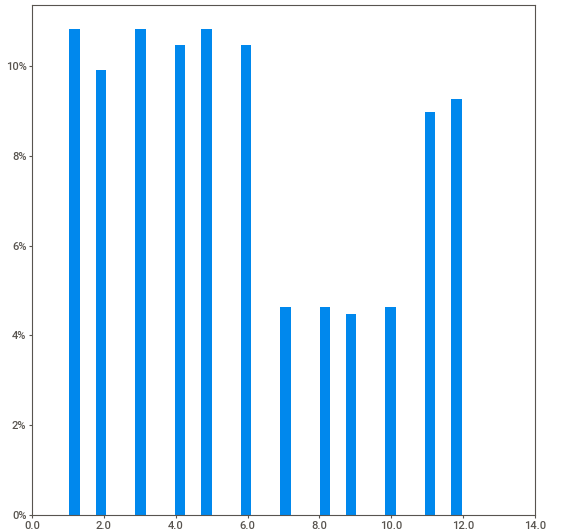
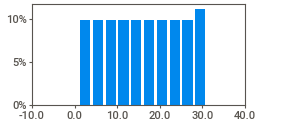
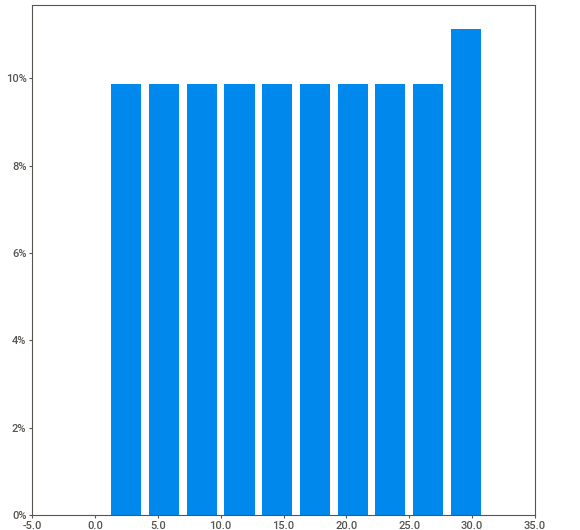
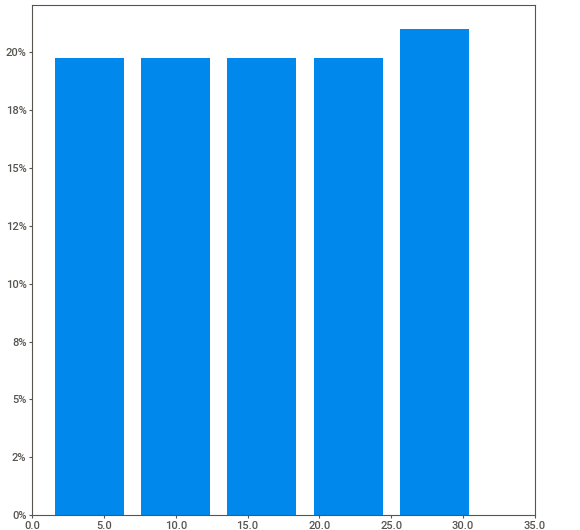
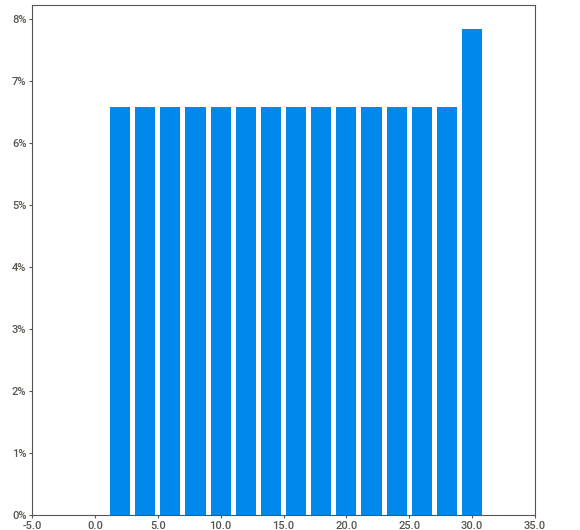
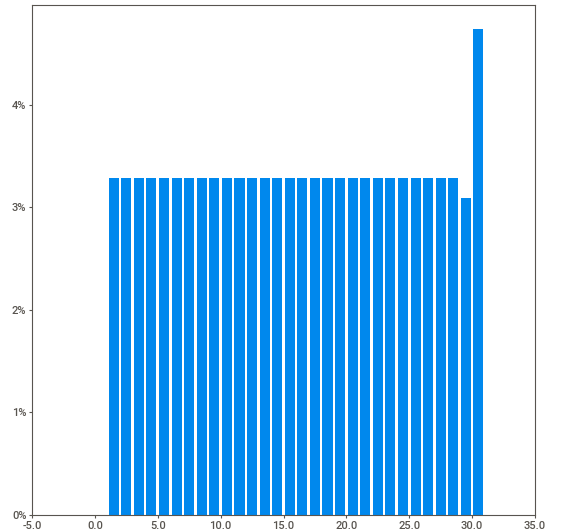
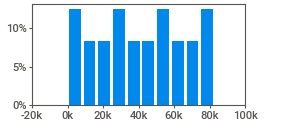
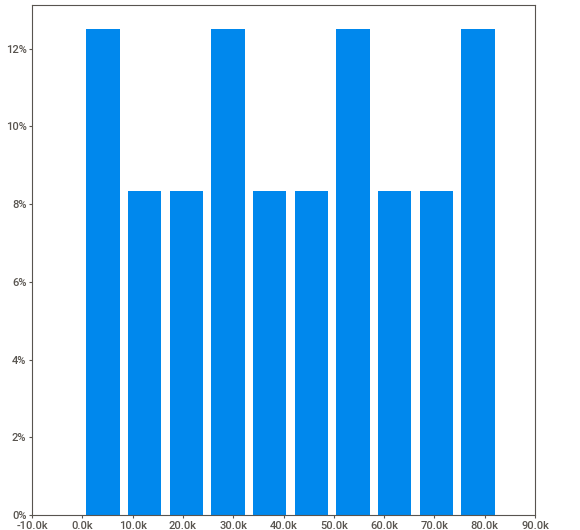
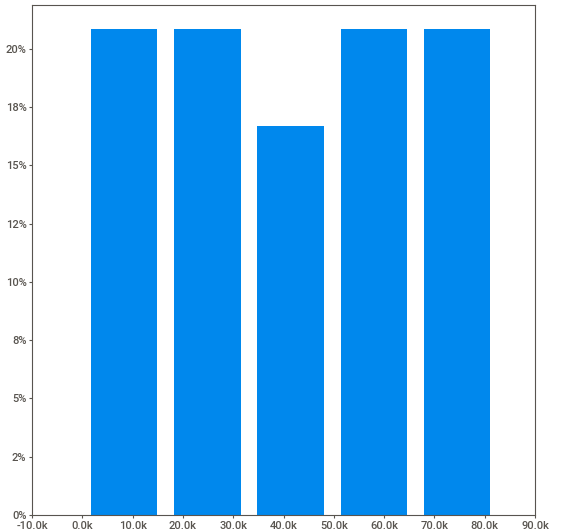
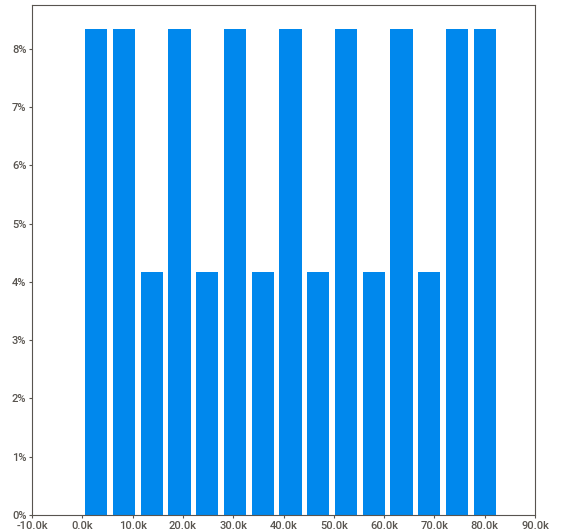
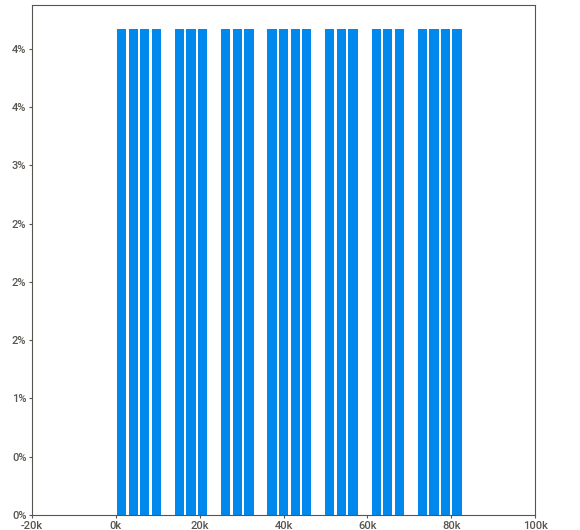
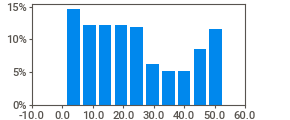
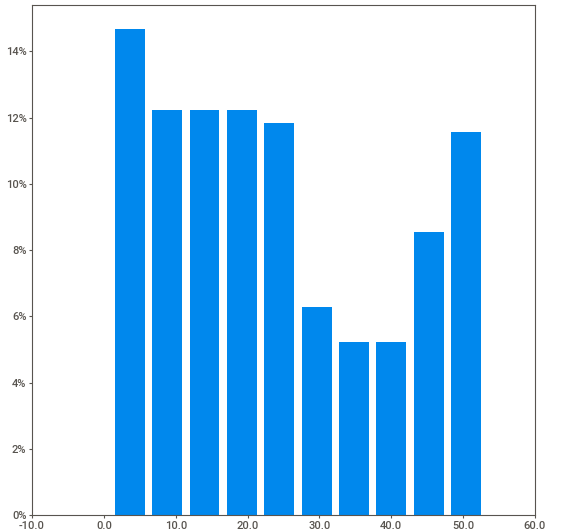
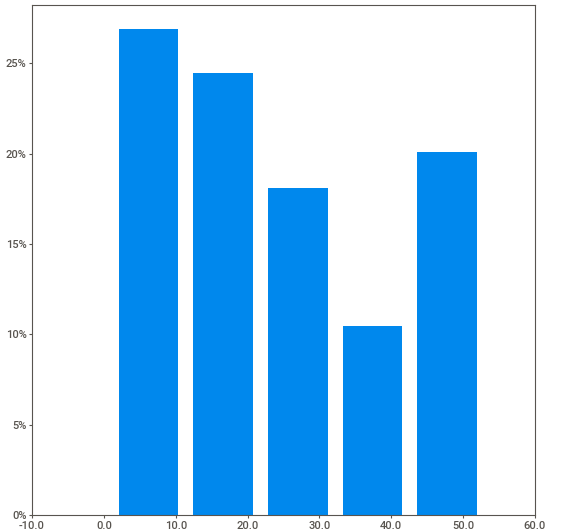
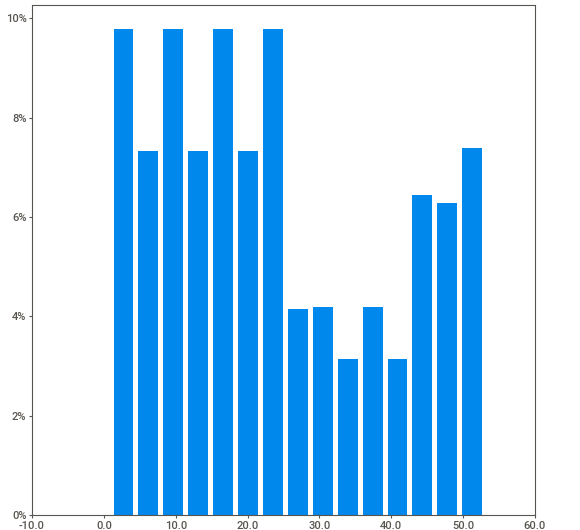
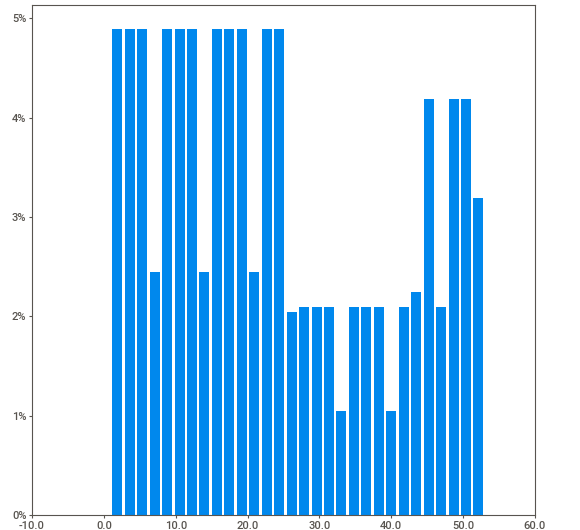
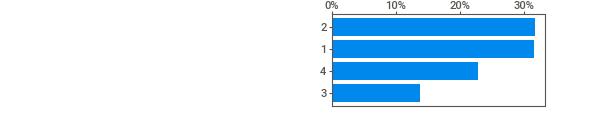
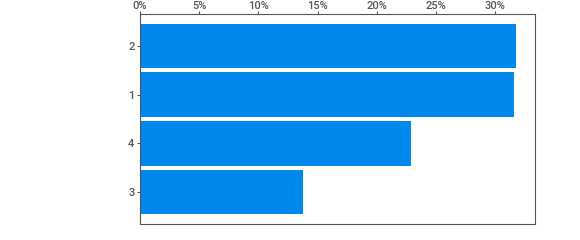
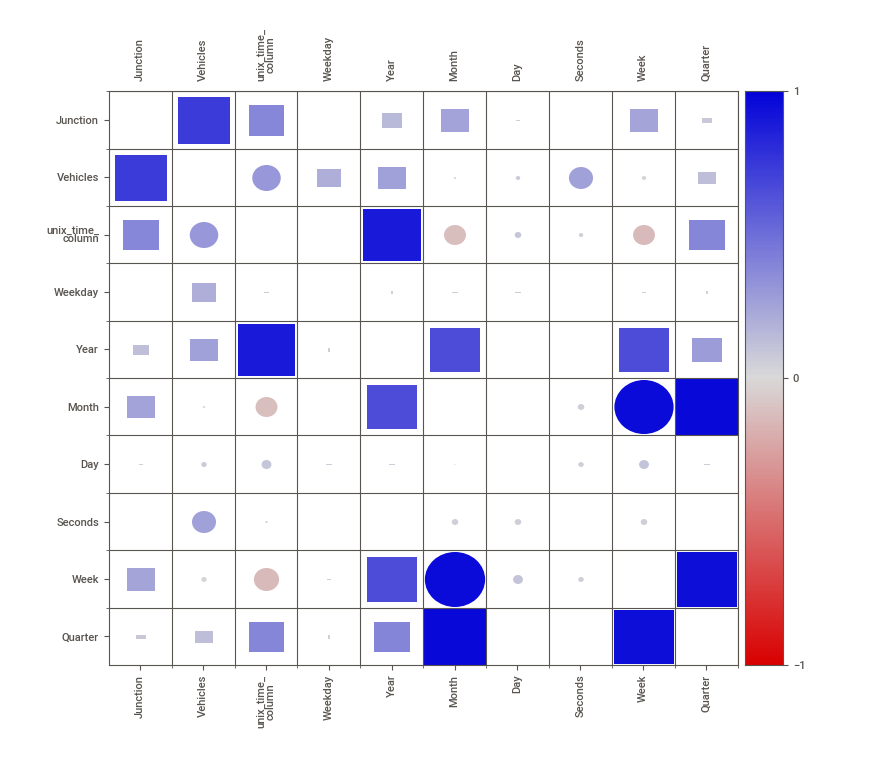
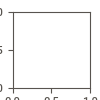

In [20]:
# Generating a report of the data
import sweetviz as sv
analysis = sv.analyze(df)
analysis.show_notebook() # or export with show_html()

# Model Building

## LSTM Predicting Vehicles at a Junction

In [68]:
#create your training and validation sets here
data = int(len(df.index))

#Take Random data subset
data_rand = df.iloc[0:data,:]

#split data subset 80/20 for train/validation
eighty_percent = int(data * 0.8)
train_df = data_rand.iloc[0:eighty_percent]
val_df = data_rand.drop(train_df.index)

In [69]:
# Saving val df
val_df.to_csv('/content/drive/My Drive/val_df_final.csv', index = None)

In [70]:
val_df.head()

,DateTime,Junction,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
38496,2016-11-23 00:00:00,3,17,1.479859e+09,2,2016,11,23,0,47,4
38497,2016-11-23 01:00:00,3,12,1.479863e+09,2,2016,11,23,3600,47,4
38498,2016-11-23 02:00:00,3,10,1.479866e+09,2,2016,11,23,7200,47,4
38499,2016-11-23 03:00:00,3,7,1.479870e+09,2,2016,11,23,10800,47,4
38500,2016-11-23 04:00:00,3,4,1.479874e+09,2,2016,11,23,14400,47,4


In [71]:
# Checking shape
train_df.shape, val_df.shape

((38496, 11), (9624, 11))

In [72]:
# Initializing arrays
seq_arrays = []
seq_labs = []

In [73]:
# we'll start out with a 3 hour 
seq_length = 3
ph = 1

feat_cols = ['Vehicles']

#create list of sequence length for vehicles
#Based my for loop to go through the sequence length GAP readings by using 
#the Kaggle link: https://www.kaggle.com/code/nilakay/lstm-time-series-iot
for i in range(len(train_df) - seq_length - ph):
    seq = df.iloc[i:i + seq_length][feat_cols].to_numpy()
    seq_arrays.append(seq)
    seq_lab = df.iloc[i+ seq_length + ph][feat_cols].to_numpy()[-1]
    seq_labs.append(seq_lab)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

#Reshape seq_arrays

seq_arrays = seq_arrays.reshape((seq_arrays.shape[0], seq_arrays.shape[1], len(feat_cols)))

In [74]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [75]:
# Reshaping the array
seq_labs = seq_labs.reshape(-1,1)

In [76]:
seq_arrays.shape, seq_lab.shape

((38492, 3, 1), ())

In [77]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2] #number of features selected with sequence_cols
nb_out = seq_labs.shape[1] #expected output length

model = Sequential()
#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=15, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))
# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out))
model.add(Activation('relu'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 15)             1020      
                                                                 
 dropout_10 (Dropout)        (None, 3, 15)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                1040      
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,071
Trainable params: 2,071
Non-traina

In [78]:
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
74/74 - 5s - loss: 865.2448 - mse: 865.2448 - val_loss: 99.2273 - val_mse: 99.2273 - 5s/epoch - 72ms/step
Epoch 2/100
74/74 - 1s - loss: 594.5787 - mse: 594.5787 - val_loss: 67.2964 - val_mse: 67.2964 - 517ms/epoch - 7ms/step
Epoch 3/100
74/74 - 1s - loss: 445.0924 - mse: 445.0924 - val_loss: 54.2138 - val_mse: 54.2138 - 542ms/epoch - 7ms/step
Epoch 4/100
74/74 - 1s - loss: 346.7910 - mse: 346.7910 - val_loss: 52.7986 - val_mse: 52.7986 - 545ms/epoch - 7ms/step
Epoch 5/100
74/74 - 0s - loss: 281.1135 - mse: 281.1135 - val_loss: 52.9490 - val_mse: 52.9490 - 494ms/epoch - 7ms/step
Epoch 6/100
74/74 - 1s - loss: 234.9440 - mse: 234.9440 - val_loss: 52.1495 - val_mse: 52.1495 - 541ms/epoch - 7ms/step
Epoch 7/100
74/74 - 1s - loss: 201.6141 - mse: 201.6141 - val_loss: 53.5066 - val_mse: 53.5066 - 507ms/epoch - 7ms/step
Epoch 8/100
74/74 - 0s - loss: 177.8585 - mse: 177.8585 - val_loss: 53.8492 - val_mse: 53.8492 - 492ms/epoch - 7ms/step
Epoch 9/100
74/74 - 0s - loss: 158.5394 - 

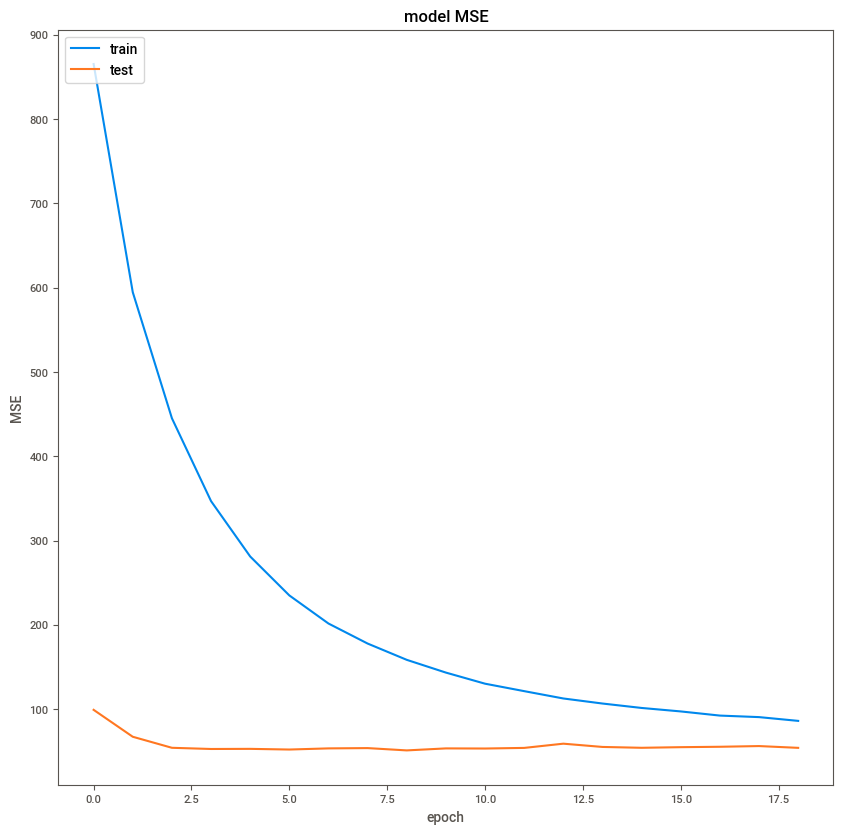

In [79]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

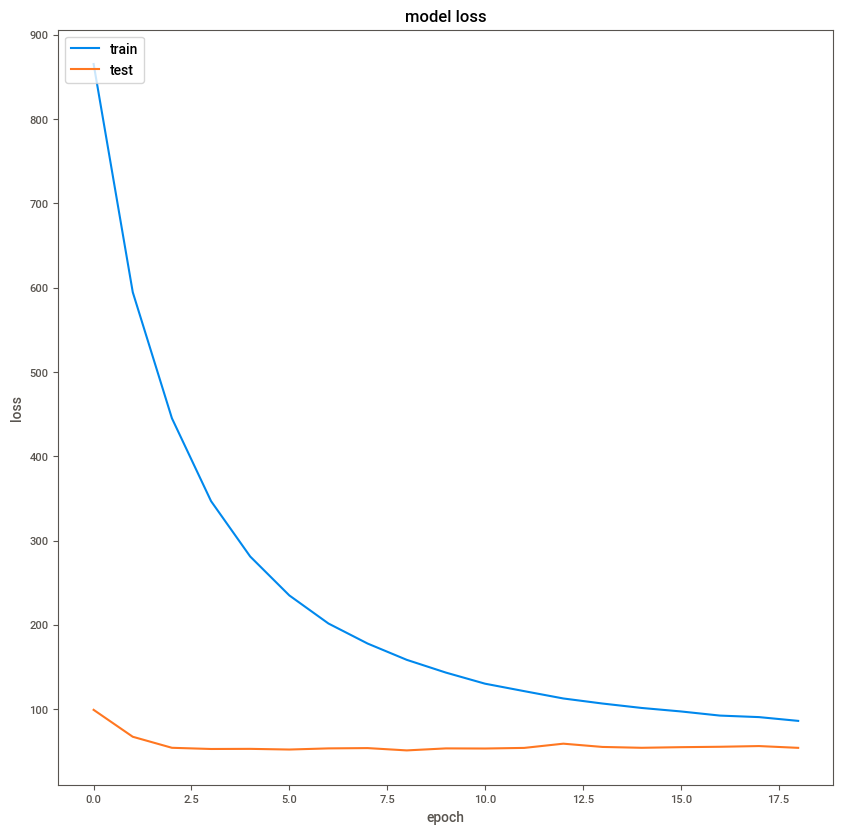

In [80]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

This graph shows some learning in our model.

In [81]:
val_arrays = []
val_labs = []

#create list of vehicle readings starting with a minimum of two readings
for i in range(2,len(val_df) - seq_length - ph):
  if (i < seq_length):
      seq = val_df.iloc[0:i][feat_cols].to_numpy()
      val_arrays.append(seq)
      val_lab = val_df.iloc[i + ph][feat_cols].to_numpy()[-1]
      val_labs.append(val_lab)
  else:
      seq = val_df.iloc[i:i + seq_length][feat_cols].to_numpy()
      val_arrays.append(seq)
      val_lab = val_df.iloc[i + seq_length + ph][feat_cols].to_numpy()[-1]
      val_labs.append(val_lab)
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = tf.keras.utils.pad_sequences(
    val_arrays,
    maxlen=None,
    dtype='float32',
    padding='pre',
    truncating='pre',
    value=0.0
)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

301/301 - 2s - loss: 46.3639 - mse: 46.3323 - 2s/epoch - 7ms/step

MSE: 46.33232498168945
301/301 [==============================] - 2s 3ms/step


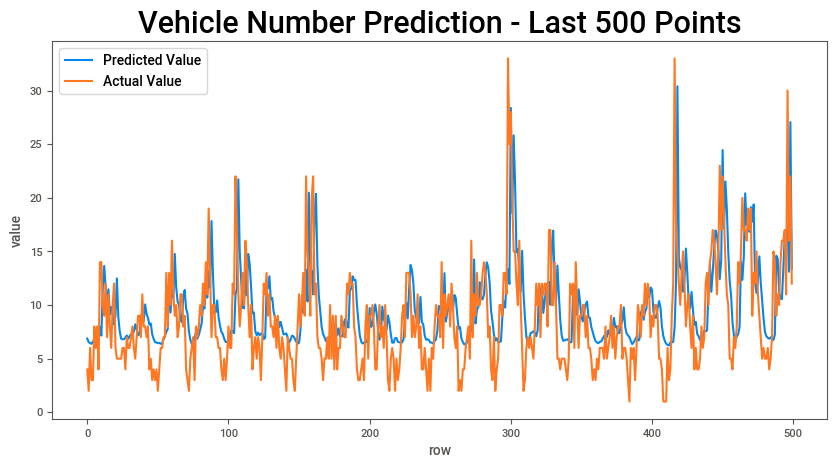

In [82]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('/content/drive/My Drive/submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Vehicle Number Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [36]:
# Saving to CSV for visualization
sub = pd.merge(val_df, test_set, left_index = True, right_index = True)
sub.to_csv('/content/drive/My Drive/projectlstm.csv')

In [37]:
val_df.shape, test_set.shape

((9624, 11), (9618, 1))

Overall, the model did a good job at predicting traffic in a time sequence. However, there are some peaks and valleys that are underestimated.

## Junction Prediction Using A Neural Network

For our second feature prediction, we will use junction. Based on our observations so far, Junction will not be a good feature to predict. We will attempt to make this problem binary, oversampling, and undersampling to see if this can help make a preidiction.

In [38]:
df.head()

,DateTime,Junction,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
0,2015-11-01 00:00:00,1,15,1.446336e+09,6,2015,11,1,0,44,4
1,2015-11-01 01:00:00,1,13,1.446340e+09,6,2015,11,1,3600,44,4
2,2015-11-01 02:00:00,1,10,1.446343e+09,6,2015,11,1,7200,44,4
3,2015-11-01 03:00:00,1,7,1.446347e+09,6,2015,11,1,10800,44,4
4,2015-11-01 04:00:00,1,9,1.446350e+09,6,2015,11,1,14400,44,4


In [39]:
# Checking shape
df.shape

(48120, 11)

### NN Model 1 (No sampling)
For this model, we did not sample despite the classes being unbalanced. This model performed better than undersampling. This model uses the four junctions instead of being binary. We discovered binary was not a good method to use. The MSE ended up being 0.1793 with the loss curve for validation being flat. Please see below this model for our oversampling and undersampling models. 

In [40]:
# One hot encoding junction
one_hot_encoded = pd.get_dummies(df, columns=["Junction"]) # Drop First?
X = one_hot_encoded.drop(['Junction_1', 'Junction_2', 'Junction_3','Junction_4', 'DateTime'],axis=1)
y = one_hot_encoded[['Junction_1', 'Junction_2', 'Junction_3','Junction_4']]

In [41]:
# Splitting into test, train, val
X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,shuffle = True, stratify = y)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

In [43]:
#Initializing the neural network
model_1 = Sequential()
#Adding the input layer with 16 neurons and relu as activation function
model_1.add(Dense(16,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_1.add(Dropout(0.2))
# Adding the first hidden layer with 8 neurons with relu as activation functions
model_1.add(Dense(8,activation='relu'))
# Adding dropout with ratio of 0.1
model_1.add(Dropout(0.1))
# Adding the output layer with 4 neurons with softmax as activation function
model_1.add(Dense(4,activation='softmax'))

In [44]:
# Summary of the model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16)                160       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________


In [45]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.01)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [46]:
#Fitting the ANN with batch_size = 32 and 30 epochs 
history_1 = model_1.fit(X_train,y_train,batch_size=32,epochs=30,verbose=1, validation_data=(X_val,y_val))

Epoch 1/30
1203/1203 [==============================] - 8s 6ms/step - loss: 433692.2500 - mse: 0.1856 - val_loss: 0.5360 - val_mse: 0.1792
Epoch 2/30
1203/1203 [==============================] - 4s 4ms/step - loss: 3429.9473 - mse: 0.1804 - val_loss: 0.5360 - val_mse: 0.1792
Epoch 3/30
1203/1203 [==============================] - 4s 4ms/step - loss: 0.5361 - mse: 0.1792 - val_loss: 0.5362 - val_mse: 0.1793
Epoch 4/30
1203/1203 [==============================] - 5s 4ms/step - loss: 0.5361 - mse: 0.1792 - val_loss: 0.5360 - val_mse: 0.1792
Epoch 5/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5362 - mse: 0.1793 - val_loss: 0.5362 - val_mse: 0.1793
Epoch 6/30
1203/1203 [==============================] - 4s 3ms/step - loss: 0.5362 - mse: 0.1793 - val_loss: 0.5364 - val_mse: 0.1795
Epoch 7/30
1203/1203 [==============================] - 9s 8ms/step - loss: 0.5362 - mse: 0.1793 - val_loss: 0.5360 - val_mse: 0.1791
Epoch 8/30
1203/1203 [==============================] 

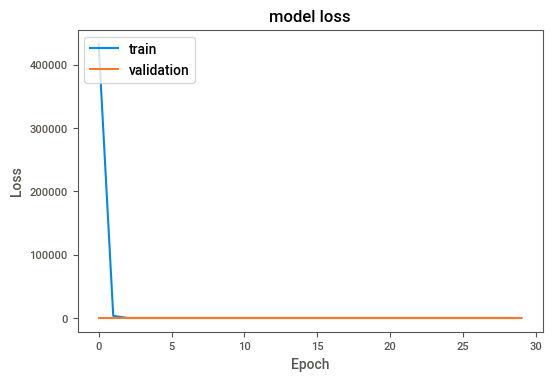

In [47]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The validation loss is flat, which leads us to think that the model is not learning.

In [48]:
results = model_1.evaluate(X_test, y_test)

301/301 [==============================] - 1s 3ms/step - loss: 0.5364 - mse: 0.1793


In [49]:
y_pred2 = model_1.predict(X_test)

301/301 [==============================] - 1s 2ms/step


In [50]:
test_set2 = pd.DataFrame(y_pred2)

In [51]:
test_set2.to_csv('/content/drive/My Drive/y_pred4.csv', index = None)

In [52]:
test_set2.head()

,0,1,2,3
0,0.283273,0.314355,0.322766,0.079606
1,0.283273,0.314355,0.322766,0.079606
2,0.283273,0.314355,0.322766,0.079606
3,0.283273,0.314355,0.322766,0.079606
4,0.283273,0.314355,0.322766,0.079606


As you can see here the probabilities are the same all the way down, so this has not been a good method of predicting junction.

In [53]:
# Making labels for possible visualization.
threshold = 0.249

def get_label(row):
    if row[0] > threshold:
        return 1
    elif row[1] > threshold:
        return 2
    elif row[2] > threshold:
        return 2
    elif row[3] > threshold:
        return 4
    else:
        return "Unknown"
# Assigning labels
test_set2["Label"] = test_set2.apply(get_label, axis=1)

test_set2.head()

,0,1,2,3,Label
0,0.283273,0.314355,0.322766,0.079606,1
1,0.283273,0.314355,0.322766,0.079606,1
2,0.283273,0.314355,0.322766,0.079606,1
3,0.283273,0.314355,0.322766,0.079606,1
4,0.283273,0.314355,0.322766,0.079606,1


### NN Model 2 (Oversampling)
This model performed the best in our opinion because it is clear from the visualization that the model was actually learning. The loss curve for training and validation looks great, and the mse turned out to be 0.1878. Please see below this model for the undersampling method we used.

In [54]:
y_train.head()

,Junction_1,Junction_2,Junction_3,Junction_4
5430,1,0,0,0
44183,0,0,0,1
46148,0,0,0,1
42415,0,0,1,0
36312,0,0,1,0


In [55]:
# convert y_train to a numpy array
y_train_np = np.array(y_train)

In [56]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE("minority")
X_train_over, y_train_over = sm.fit_resample(X_train, y_train_np)

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [57]:
print("Before OverSampling, count of junction 1-4': {}".format(sum(y_train_np == 1)))

print("After OverSampling, count of junction 1-4': {}".format(sum(y_train_over == 1)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, count of junction 1-4': [11673 11674 11674  3475]
After OverSampling, count of junction 1-4': [11673 11674 11674 11674]
After OverSampling, the shape of train_X: (46695, 9)
After OverSampling, the shape of train_y: (46695, 4) 



In [58]:
# convert y_train to a numpy array
y_test_np = np.array(y_test)

In [59]:
y_test_np

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [60]:
# Checking test shape
sum(y_test_np == 1)

print("After OverSampling, count of junction test set 1-4': {}".format(sum(y_test_np == 1)))

After OverSampling, count of junction test set 1-4': [2919 2918 2918  869]


In [61]:
X_train_over.head(20)

,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter
0,22,1.465884e+09,1,2016,6,14,21600,24,2
1,10,1.484694e+09,1,2017,1,17,82800,3,1
2,6,1.491768e+09,6,2017,4,9,72000,14,2
3,9,1.493968e+09,4,2017,5,5,25200,18,2
4,16,1.471997e+09,2,2016,8,24,0,34,3
5,46,1.490324e+09,4,2017,3,24,10800,12,1
6,16,1.477494e+09,2,2016,10,26,54000,43,4
7,27,1.485583e+09,5,2017,1,28,21600,4,1
8,49,1.488038e+09,5,2017,2,25,57600,8,1
9,32,1.483445e+09,1,2017,1,3,43200,1,1


In [62]:
# Checking if SMOTE worked correctly
X_train_over[X_train_over['Day']> 31]

,Vehicles,unix_time_column,Weekday,Year,Month,Day,Seconds,Week,Quarter


In [63]:
#Initializing the neural network
model_2 = Sequential()
#Adding the input layer with 256 neurons and relu as activation function
model_2.add(Dense(256,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_2.add(Dropout(0.2))
model_2.add(Dense(128,activation='softmax',input_dim = 9))
# Adding dropout with ratio of 0.2
model_2.add(Dropout(0.2))
model_2.add(Dense(64))
# Adding dropout with ratio of 0.1
model_2.add(Dropout(0.1))
model_2.add(Dense(32,activation='softmax'))
# Adding dropout with ratio of 0.1
model_2.add(Dropout(0.1))
model_2.add(Dense(16,activation='relu'))
# Adding dropout with ratio of 0.1
model_2.add(Dropout(0.1))
model_2.add(Dense(8))
# Adding dropout with ratio of 0.1
model_2.add(Dropout(0.1))
# Adding the output layer with 4 neurons with softmax function
model_2.add(Dense(4,activation='softmax'))

In [64]:
# Summary of the model
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               2560      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)               

In [65]:
#Compiling the ANN with SGD optimizer 
optimizer = tf.keras.optimizers.SGD(0.001)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [66]:
#Fitting the ANN 
history_2 = model_2.fit(X_train_over,y_train_over,batch_size=32,epochs=30,verbose=1, validation_data=(X_val,y_val))

Epoch 1/30
1460/1460 [==============================] - 12s 7ms/step - loss: 0.6676 - mse: 0.1877 - val_loss: 0.6430 - val_mse: 0.1877
Epoch 2/30
1460/1460 [==============================] - 8s 5ms/step - loss: 0.6266 - mse: 0.1881 - val_loss: 0.6111 - val_mse: 0.1881
Epoch 3/30
1460/1460 [==============================] - 10s 7ms/step - loss: 0.6002 - mse: 0.1884 - val_loss: 0.5900 - val_mse: 0.1883
Epoch 4/30
1460/1460 [==============================] - 10s 7ms/step - loss: 0.5840 - mse: 0.1886 - val_loss: 0.5774 - val_mse: 0.1883
Epoch 5/30
1460/1460 [==============================] - 7s 5ms/step - loss: 0.5750 - mse: 0.1886 - val_loss: 0.5705 - val_mse: 0.1882
Epoch 6/30
1460/1460 [==============================] - 8s 5ms/step - loss: 0.5700 - mse: 0.1885 - val_loss: 0.5669 - val_mse: 0.1881
Epoch 7/30
1460/1460 [==============================] - 8s 6ms/step - loss: 0.5677 - mse: 0.1885 - val_loss: 0.5650 - val_mse: 0.1880
Epoch 8/30
1460/1460 [==============================] - 7s 

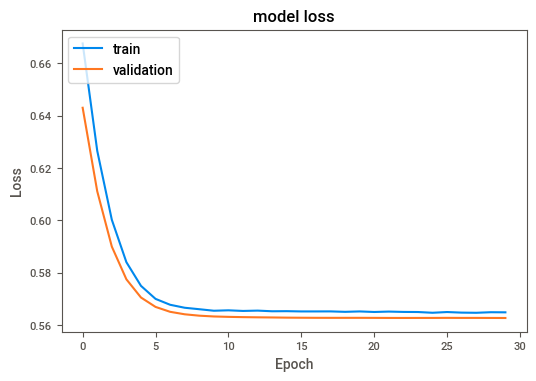

In [67]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From this curve you can see that this model is actually learning. We think this was the best architecture for this problem. However, all weights turned out to be the same despite trying various methods. Please see below for weights.

In [83]:
results = model_2.evaluate(X_test, y_test)

301/301 [==============================] - 1s 3ms/step - loss: 0.5627 - mse: 0.1876


In [84]:
y_pred1 = model_2.predict(X_test)

301/301 [==============================] - 1s 2ms/step


In [86]:
test_set1 = pd.DataFrame(y_pred1)

In [87]:
# Saving for possible visualizations
test_set1.to_csv('/content/drive/My Drive/y_pred10.csv', index = None)

In [88]:
# Assigning labels to possibly visualize
threshold = 0.249

# Define a function to apply the threshold and return the label
def get_label(row):
    if row[0] > threshold:
        return 1
    elif row[1] > threshold:
        return 2
    elif row[2] > threshold:
        return 2
    elif row[3] > threshold:
        return 4
    else:
        return "Unknown"
# Apply the function to each row of the predictions DataFrame to create the labels
test_set1["Label"] = test_set1.apply(get_label, axis=1)

# Print the resulting DataFrame with labels
test_set1.head()

,0,1,2,3,Label
0,0.250731,0.248157,0.249787,0.251325,1
1,0.250731,0.248157,0.249787,0.251325,1
2,0.250731,0.248157,0.249787,0.251325,1
3,0.250731,0.248157,0.249787,0.251325,1
4,0.250731,0.248157,0.249787,0.251325,1


In [89]:
test_set1.to_csv('/content/drive/My Drive/y_pred11.csv', index = None)

### Model 3 (Undersampling)
This model did not learn much, so we did not move forward with labeling the data. See the graph below for a better explaination as to why.

In [90]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train_np)

In [91]:
print("Before Under Sampling, count of junctions 1-4': {}".format(sum(y_train_np == 1)))
print("After Under Sampling, count of junctions 1-4': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, count of junctions 1-4': [11673 11674 11674  3475]
After Under Sampling, count of junctions 1-4': [3475 3475 3475 3475]
After Under Sampling, the shape of train_X: (13900, 9)
After Under Sampling, the shape of train_y: (13900, 4) 



In [92]:
#Initializing the neural network
model_3 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_3.add(Dense(32,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_3.add(Dropout(0.2))
model_3.add(Dense(16,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
# Adding layer with 8 neurons with softmax as activation function
model_3.add(Dense(8,activation='softmax'))
# Adding dropout with ratio of 0.1
model_3.add(Dropout(0.1))
# Adding the output layer with 4 neurons with softmax as activation
model_3.add(Dense(4,activation='softmax'))

In [93]:
# Summary of the model
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                320       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,020
Trainable params: 1,020
Non-traina

In [94]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.Adam(0.01)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [95]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
history_3 = model_3.fit(X_train_un,y_train_un,batch_size=32,epochs=30,verbose=1, validation_data=(X_val,y_val))

Epoch 1/30
435/435 [==============================] - 5s 6ms/step - loss: 0.5739 - mse: 0.1896 - val_loss: 0.5647 - val_mse: 0.1887
Epoch 2/30
435/435 [==============================] - 2s 5ms/step - loss: 0.5637 - mse: 0.1879 - val_loss: 0.5620 - val_mse: 0.1873
Epoch 3/30
435/435 [==============================] - 2s 5ms/step - loss: 0.5634 - mse: 0.1880 - val_loss: 0.5596 - val_mse: 0.1862
Epoch 4/30
435/435 [==============================] - 2s 5ms/step - loss: 0.5631 - mse: 0.1879 - val_loss: 0.5605 - val_mse: 0.1866
Epoch 5/30
435/435 [==============================] - 4s 8ms/step - loss: 0.5629 - mse: 0.1879 - val_loss: 0.5553 - val_mse: 0.1843
Epoch 6/30
435/435 [==============================] - 2s 5ms/step - loss: 0.5629 - mse: 0.1879 - val_loss: 0.5626 - val_mse: 0.1877
Epoch 7/30
435/435 [==============================] - 2s 5ms/step - loss: 0.5630 - mse: 0.1879 - val_loss: 0.5620 - val_mse: 0.1873
Epoch 8/30
435/435 [==============================] - 2s 5ms/step - loss: 0.

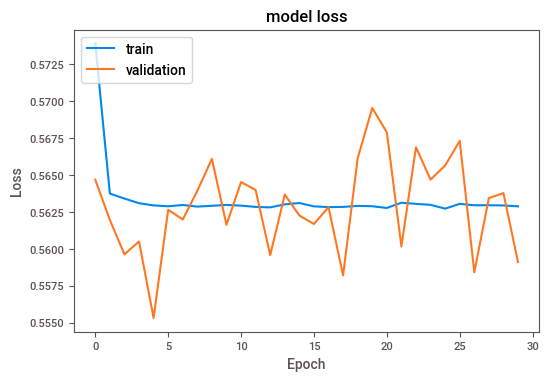

In [96]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

This model is not learning at all, which leads us to believe that undersampling is not a great method to predict junction.

In [97]:
results = model_1.evaluate(X_val, y_val)

301/301 [==============================] - 1s 3ms/step - loss: 0.5364 - mse: 0.1793


### Binary NN
As per Professor Tran's suggestion, we will try the final version of this model as being binary. Please see below this model for our no sampling, oversampling, and undersampling versions. The MSE ended up being 0.2500 on the test set.

In [163]:
# Taking out Junction 3 and 4 to see if binary works better
df = df[df['Junction'] != 3]

In [164]:
df = df[df['Junction'] != 4]

In [165]:
# One hot encouding junction
one_hot_encoded = pd.get_dummies(df, columns=["Junction"]) # Drop First?
X = one_hot_encoded.drop(['Junction_1', 'Junction_2', 'DateTime'],axis=1)
y = one_hot_encoded[['Junction_1', 'Junction_2']]

In [166]:
# Splitting into test, train, val
X_large, X_test, y_large, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,shuffle = True, stratify = y)

In [167]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

In [168]:
y.head()

,Junction_1,Junction_2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [170]:
#Initializing the neural network
model_4 = Sequential()
#Adding the input layer with 256 neurons and relu as activation function
model_4.add(Dense(256,activation='relu',input_dim = 9))
# Adding dropout with ratio of 0.2
model_4.add(Dropout(0.2))
model_4.add(Dense(128,activation='sigmoid',input_dim = 9))
# Adding dropout with ratio of 0.2
model_4.add(Dropout(0.2))
model_4.add(Dense(64))
# Adding dropout with ratio of 0.1
model_4.add(Dropout(0.1))
model_4.add(Dense(32,activation='sigmoid'))
# Adding dropout with ratio of 0.1
model_4.add(Dropout(0.1))
model_4.add(Dense(16))
# Adding dropout with ratio of 0.1
model_4.add(Dropout(0.1))
model_4.add(Dense(8))
# Adding dropout with ratio of 0.1
model_4.add(Dropout(0.1))
# Adding the output layer
model_4.add(Dense(2,activation='sigmoid'))

In [171]:
# Summary of the model
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 256)               2560      
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)               

In [172]:
#Compiling the ANN with Adam optimizer 
optimizer = tf.keras.optimizers.SGD(0.01)
# Complining the model with binary cross entropy as loss function and accuracy as metrics
model_4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['mse'])

In [173]:
#Fitting the ANN 
history_4 = model_4.fit(X_train,y_train,batch_size=32,epochs=30,verbose=1, validation_data=(X_val,y_val))

Epoch 1/30
730/730 [==============================] - 7s 7ms/step - loss: 0.7064 - mse: 0.2563 - val_loss: 0.6931 - val_mse: 0.2500
Epoch 2/30
730/730 [==============================] - 4s 5ms/step - loss: 0.6999 - mse: 0.2533 - val_loss: 0.6934 - val_mse: 0.2501
Epoch 3/30
730/730 [==============================] - 4s 5ms/step - loss: 0.6967 - mse: 0.2518 - val_loss: 0.6933 - val_mse: 0.2501
Epoch 4/30
730/730 [==============================] - 5s 7ms/step - loss: 0.6962 - mse: 0.2515 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 5/30
730/730 [==============================] - 4s 5ms/step - loss: 0.6959 - mse: 0.2514 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 6/30
730/730 [==============================] - 4s 5ms/step - loss: 0.6952 - mse: 0.2510 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 7/30
730/730 [==============================] - 4s 6ms/step - loss: 0.6951 - mse: 0.2509 - val_loss: 0.6932 - val_mse: 0.2500
Epoch 8/30
730/730 [==============================] - 5s 7ms/step - loss: 0.

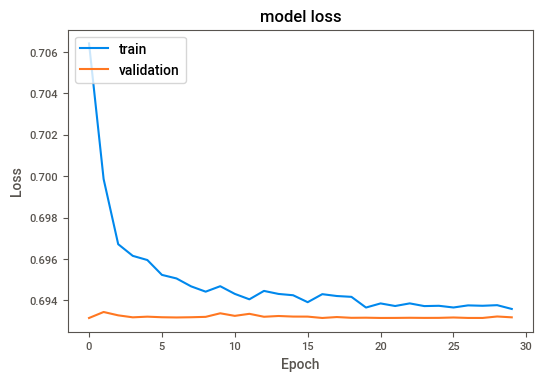

In [174]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

This model performed worst than our oversampling and no sampling. We assume this happened because there is less data since we dropped junction 3 & 4.

In [204]:
results = model_4.evaluate(X_test, y_test)

183/183 [==============================] - 1s 6ms/step - loss: 0.6932 - mse: 0.2500


In [205]:
y_pred3 = model_4.predict(X_test)

183/183 [==============================] - 1s 3ms/step


In [206]:
y_pred3

array([[0.4943522, 0.5017387],
       [0.4943522, 0.5017387],
       [0.4943522, 0.5017387],
       ...,
       [0.4943522, 0.5017387],
       [0.4943522, 0.5017387],
       [0.4943522, 0.5017387]], dtype=float32)

In [207]:
test_set3 = pd.DataFrame(y_pred3)

In [208]:
# Saving for possible visualizations.
test_set3.to_csv('/content/drive/My Drive/y_pred12.csv', index = None)

In [209]:
test_set3

,0,1
0,0.494352,0.501739
1,0.494352,0.501739
2,0.494352,0.501739
3,0.494352,0.501739
4,0.494352,0.501739
...,...,...
5832,0.494352,0.501739
5833,0.494352,0.501739
5834,0.494352,0.501739
5835,0.494352,0.501739


In [211]:
# Assume your predicted probabilities are stored in a Pandas DataFrame called "predictions"
# with columns "Junction 1", "Junction 2", "Junction 3", "Junction 4"
# and each row corresponds to a single prediction

# Set a threshold for classification (e.g. 0.5)
threshold = 0.4951

# Define a function to apply the threshold and return the label
def get_label(row):
    if row[0] > threshold:
        return 1
    elif row[1] > threshold:
        return 2
    else:
        return "Unknown"
# Apply the function to each row of the predictions DataFrame to create the labels
test_set3["Label"] = test_set3.apply(get_label, axis=1)

# Print the resulting DataFrame with labels
test_set3.head()

,0,1,Label
0,0.494352,0.501739,2
1,0.494352,0.501739,2
2,0.494352,0.501739,2
3,0.494352,0.501739,2
4,0.494352,0.501739,2


Overall, oversampling was the best method to train a neural network to predict junction. Using oversampling helped the model best learn from the data.